In [36]:
import arviz as az
import numpyro
from numpyro.infer import Predictive, log_likelihood
import jax
import jax.random as random
import jax.numpy as jnp
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import dill
import seaborn as sns

# Add ../code to PYTHON_PATH
sys.path.insert(0, "../code")
import bnns.model_configs
from datasets.synthetic import SyntheticDataset
from datasets.uci import UCIDataset, dataset_names, load_standard_splits
from utils import normalize

plt.style.use("seaborn-v0_8-whitegrid")

In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
model_names = [name for name in dir(bnns.model_configs)]
models = [getattr(bnns.model_configs, name) for name in model_names]
#datasets = [SyntheticDataset()] + [UCIDataset(name) for name in dataset_names]
dataset = SyntheticDataset()
dataset_name = "synthetic"

In [39]:
# Adjust as needed
SAMPLE_PATH = "../samples/synthetic-2"
DATASET = "SyntheticDataset"
SEED = 10


# Load samples
def load_samples():
    methods = os.listdir(SAMPLE_PATH)
    samples = []
    for method in methods:
        path = os.path.join(SAMPLE_PATH, method, "synthetic")
        if method == "SVI":
            splits = os.listdir(path)
            for split in splits:
                with open(os.path.join(path, split), "rb") as f:
                    svi_result = dill.load(f)
                model_name = "_".join(split.split(".")[0].split("_")[:-1])
                split_ind = split.split(".")[0].split("_")[-1]
                model = getattr(bnns.model_configs, model_name)
                params = svi_result["params"]
                guide = svi_result["guide"]
                predictive = Predictive(guide, params=params, num_samples=1)
                post_draws = predictive(jax.random.PRNGKey(SEED), None)
                samples.append({
                    "model": model,
                    "method": method,
                    "method_name": "MAP" if method == "SVI" else "NUTS" if method == "HMC" else method,
                    "model": model_name,
                    "split": split_ind,
                    "post_draws": post_draws
                })
        if method == "HMC":
            splits = os.listdir(path)
            for split in splits:
                if ".nc" not in split:
                    continue
                inference_data = az.from_netcdf(os.path.join(path, split))
                model_name = "_".join(split.split(".")[0].split("_")[:-1])
                split_ind = split.split(".")[0].split("_")[-1]
                model = getattr(bnns.model_configs, model_name)

                post_draws = inference_data.to_dict()["posterior"]
                post_draws.pop("y_probs", None)

                with open(os.path.join(path, split.replace(".nc", "_metadata.dill")), "rb") as f:
                    metadata = dill.load(f)
                samples.append({
                    "model": model,
                    "method": method,
                    "method_name": "MAP" if method == "SVI" else "NUTS" if method == "HMC" else method,
                    "model": model_name,
                    "split": split_ind,
                    "post_draws": post_draws,
                    "inference_data": inference_data,
                    "time_spanned": metadata["time_spanned"],
                    "accept_prob": metadata["accept_prob"],
                })
    return samples
samples = load_samples()

In [33]:
def rmse(model, post_draws, X, y, batch_ndims):
    predictive = Predictive(model, post_draws, batch_ndims=batch_ndims)
    predictions = predictive(jax.random.PRNGKey(SEED), X, D_Y=1, sigma=dataset.noise_level)["y_loc"]
    if predictions.ndim == 2 and predictions.shape[0] == 1:
        predictions = predictions[0]
    return jnp.sqrt(((y - predictions)**2).mean()), predictions

def batch_nll(model, post_draws, X, y, batch_ndims):
    batch_size = 5120
    n_batches = X.shape[0] // batch_size + 1
    nlls = []
    post_draws = post_draws.copy()
    post_draws.pop("y_loc", None)

    for i in range(n_batches):
        start = i * batch_size
        end = (i + 1) * batch_size
        nll = -log_likelihood(model, post_draws, X[start:end], y[start:end], sigma=dataset.noise_level, batch_ndims=batch_ndims)["y"]
        nlls.append(nll)
    return jnp.mean(jnp.concat(nlls, axis=-1))

In [40]:

results = []
preds = []
for sample_dict in samples:
    model = getattr(bnns.model_configs, sample_dict["model"])
    post_draws = sample_dict["post_draws"]
    batch_ndims = 1 if sample_dict["method"] == "SVI" else 2

    split = dataset.splits[int(sample_dict["split"])]

    X_train = dataset.X_train
    X_train_normalized, X_train_mean, X_train_std = normalize(X_train, None, None)
    y_train = dataset.y_train

    X_test_between = dataset.X_test_between
    X_test_between_normalized, _, _ = normalize(X_test_between, X_train_mean, X_train_std)
    y_test_between = dataset.y_test_between

    X_test_in = dataset.X_test_in
    X_test_in_normalized, _, _ = normalize(X_test_in, X_train_mean, X_train_std)
    y_test_in = dataset.y_test_in

    X_test_entire = dataset.X_test_entire
    X_test_entire_normalized, _, _ = normalize(X_test_entire, X_train_mean, X_train_std)
    y_test_entire = dataset.y_test_entire

    if sample_dict["method"] == "HMC":
        X_train = X_train_normalized
        X_test_between = X_test_between_normalized
        X_test_in = X_test_in_normalized
        X_test_entire = X_test_entire_normalized

    # train_nll = batch_nll(model, post_draws, X_train, y_train, batch_ndims)
    # test_between_nll = batch_nll(model, post_draws, X_test_between, y_test_between, batch_ndims)
    # test_in_nll = batch_nll(model, post_draws, X_test_in, y_test_in, batch_ndims)
    # test_entire_nll = batch_nll(model, post_draws, X_test_entire, y_test_entire, batch_ndims)
    post_draws = post_draws.copy()
    post_draws.pop("y_loc", None)
    train_nll = -log_likelihood(model, post_draws, X=X_train, y=y_train, sigma=dataset.noise_level, batch_ndims=batch_ndims)["y"].mean()
    test_between_nll = -log_likelihood(model, post_draws, X=X_test_between, y=y_test_between, sigma=dataset.noise_level, batch_ndims=batch_ndims)["y"].mean()
    test_in_nll = -log_likelihood(model, post_draws, X=X_test_in, y=y_test_in, sigma=dataset.noise_level, batch_ndims=batch_ndims)["y"].mean()
    test_entire_nll = -log_likelihood(model, post_draws, X=X_test_entire, y=y_test_entire, sigma=dataset.noise_level, batch_ndims=batch_ndims)["y"].mean()

    train_rmse, y_pred_train = rmse(model, post_draws, X_train, y_train, batch_ndims)
    test_between_rmse, y_pred_test_between = rmse(model, post_draws, X_test_between, y_test_between, batch_ndims)
    test_in_rmse, y_pred_test_in = rmse(model, post_draws, X_test_in, y_test_in, batch_ndims)
    test_entire_rmse, y_pred_test_entire = rmse(model, post_draws, X_test_entire, y_test_entire, batch_ndims)

    results.append({
        "method": sample_dict["method"],
        "model": sample_dict["model"].split("_")[0],
        "width": int(sample_dict["model"].split("_")[1]),
        "split": sample_dict["split"],
        "train_nll": train_nll.mean(),
        "train_rmse": train_rmse,
        "test_between_nll": test_between_nll.mean(),
        "test_between_rmse": test_between_rmse,
        "test_in_nll": test_in_nll.mean(),
        "test_in_rmse": test_in_rmse,
        "test_entire_nll": test_entire_nll.mean(),
        "test_entire_rmse": test_entire_rmse,
    })
    preds.append({
        "y_train": y_train,
        "y_pred_train": y_pred_train,
        "y_pred_between": y_pred_test_between,
        "y_pred_in": y_pred_test_in,
        "y_pred_entire": y_pred_test_entire,
    })
results = pd.DataFrame(results)
results.sort_values(by=["method", "model", "width"], inplace=True)
results

,method,model,width,split,train_nll,train_rmse,test_between_nll,test_between_rmse,test_in_nll,test_in_rmse,test_entire_nll,test_entire_rmse
0,HMC,BNN,5,0,-0.94896346,0.0932398,114.96394,1.5254351,-0.8736493,0.10099478,67.37477,1.1726757
3,HMC,BNN,100,0,-0.99314,0.08837492,689.21466,3.7164454,-0.8160481,0.10654562,303.242,2.468302
2,HMC,CircBNN,5,0,-0.9506095,0.093063086,127.65056,1.6064508,-0.8834685,0.1000178,72.683945,1.2171079
1,HMC,CircBNN,100,0,-0.99126345,0.08858702,688.8426,3.7154446,-0.8171574,0.10644145,301.0777,2.4595177
4,HMC,SpectralBNN,5,0,-0.91108775,0.09721714,167.52089,1.8379582,-0.8235047,0.105843455,98.59004,1.4140276
5,HMC,SpectralBNN,100,0,-0.99414986,0.088260576,387.8452,2.7900853,-0.851178,0.103195764,170.924,1.8563815
7,SVI,BNN,5,0,-1.0636275,0.080002375,104.70759,1.4566485,-1.0579355,0.080710724,52.386818,1.0370195
9,SVI,BNN,100,0,-1.0954404,0.07592182,72.51767,1.215741,-1.0615696,0.080259204,72.34833,1.2143474
8,SVI,CircBNN,5,0,-1.0668265,0.07960152,68.546104,1.1826221,-0.9631155,0.09170944,51.61151,1.029516
6,SVI,CircBNN,100,0,-1.1233743,0.07214875,54.663464,1.0587456,-1.0113138,0.08629399,54.77778,1.0598248


# Synthetic data evaluation

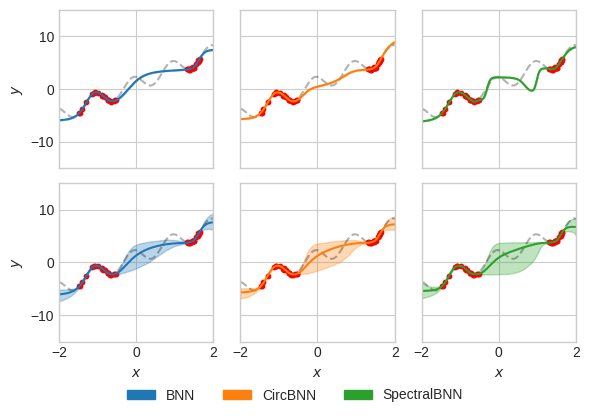

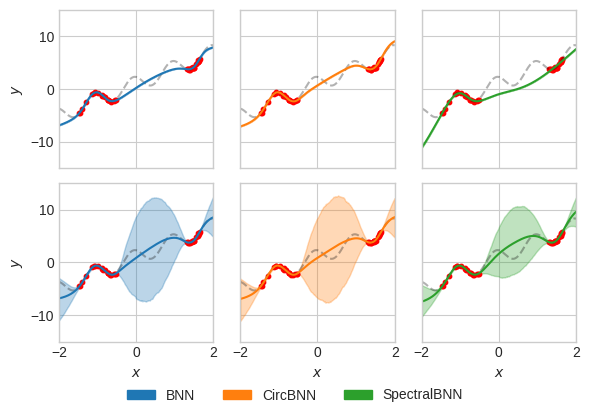

In [72]:
fig_5, axs_5 = plt.subplots(ncols=len(samples) // 4, nrows=2, figsize=(2*len(samples) // 4, 2 * 2), sharex=True, sharey=True)
fig_100, axs_100 = plt.subplots(ncols=len(samples) // 4, nrows=2, figsize=(2*len(samples) // 4, 2 * 2), sharex=True, sharey=True)

samples = sorted(samples, key=lambda x: (x["method_name"], int(x["model"].split("_")[1]), x["model"].split("_")[0]))

if len(samples) > 1:
    axs_5 = axs_5.ravel()
    axs_100 = axs_100.ravel()

X_train_normalized, X_train_mean, X_train_std = normalize(dataset.X_train, None, None)
X_plot = jnp.array(dataset.X_true).reshape(-1, 1)
X_plot_normalized, _, _ = normalize(X_plot, X_train_mean, X_train_std)
X_train = dataset.X_train
y_train = dataset.y_train
color_dict = {
    "BNN": "tab:blue",
    "CircBNN": "tab:orange",
    "SpectralBNN": "tab:green",
}

i_5 = 0
i_100 = 0
for _, sample in enumerate(samples):
    model = getattr(bnns.model_configs, sample["model"])
    post_draws = sample["post_draws"]
    batch_ndims = 1 if sample["method"] == "SVI" else 2
    color = color_dict.get(sample["model"].split("_")[0], "tab:blue")
    axs = axs_5 if int(sample["model"].split("_")[1]) == 5 else axs_100
    idx = i_5 if int(sample["model"].split("_")[1]) == 5 else i_100 
    if int(sample["model"].split("_")[1]) == 5:
        i_5 += 1
    else:
        i_100 += 1
    #X_plot = jnp.linspace(X.min(), X.max(), 1000).reshape(-1, 1)

    post_draws_no_y = post_draws.copy()
    post_draws_no_y.pop("y_loc", None)
    
    predictive = Predictive(model, posterior_samples=post_draws_no_y, batch_ndims=batch_ndims)
    y_pred = predictive(jax.random.PRNGKey(SEED), X_plot_normalized if sample["method"] == "HMC" else X_plot, D_Y=1, sigma=dataset.noise_level)["y_loc"]
    if y_pred.ndim == 3 and y_pred.shape[0] == 1:
        y_pred = y_pred[0]
    method = sample["method_name"]
    axs[idx].set_xlim(X_plot.min(), X_plot.max())
    axs[idx].set_xlim(X_plot.min(), X_plot.max())
    axs[idx].set_ylim(-15, 15)
    axs[idx].set_ylim(-15, 15)
    axs[idx].plot(X_plot, dataset.y_true, "--", color="black", alpha=0.3, label="True Function")
    axs[idx].plot(X_plot.flatten(), y_pred.mean(axis=0), label=sample["model"].split("_")[0], color=color)
    if idx > 2:
        axs[idx].set_xlabel("$x$")
    if idx % 3 == 0:
        axs[idx].set_ylabel("$y$")

    y_pred_lower, y_pred_upper = np.percentile(y_pred, [2.5, 97.5], axis=0)
    axs[idx].fill_between(X_plot.flatten(), y_pred_lower, y_pred_upper, alpha=0.3, color=color)

    axs[idx].scatter(X_train, y_train, color="red", s=10)

# Use Rectangle patches for legend instead of lines
import matplotlib.patches as mpatches
handles = [mpatches.Rectangle((0, 0), 1, 1, color=color, label=label) for label, color in color_dict.items()]
fig_5.legend(handles=handles, loc="lower center", bbox_to_anchor=(0.5, -0.05), ncol=len(color_dict), frameon=False)
fig_5.tight_layout()
fig_100.legend(handles=handles, loc="lower center", bbox_to_anchor=(0.5, -0.05), ncol=len(color_dict), frameon=False)
fig_100.tight_layout()
    #axs[idx].scatter(dataset.X_test_between, dataset.y_test_between, color="green", s=10, label="Test Data")

In [8]:
# Amont of parameters in middle layer of BNN, 100 deep
# for sample_dict in samples:
#     if sample_dict["method"] == "SVI":
#         continue
#     inference_data = sample_dict["inference_data"]
rhat_label = r"split-$\hat{R}$"
d = pd.DataFrame(columns=["model", "method", "width", "split", "ESS", rhat_label, "Time (s)", "ESS/s", "Acceptance Prob"])
for sample in samples:
    if sample["method"] == "SVI":
        continue
    post_draws = sample["post_draws"].copy()
    if "Spectral" in sample["model"]:
        for i in range(7):
            post_draws.pop(f"w_hat_{i}", None)
    summary = numpyro.diagnostics.summary(post_draws)
    w1 = summary["w1"] if "w1" in summary else summary["w_hat_0_normals"]
    ess = w1["n_eff"].flatten()
    rhat = w1["r_hat"].flatten()
    for i in range(len(w1["n_eff"].flatten())):
        d.loc[len(d)] = [sample["model"].split("_")[0], sample["method"], int(sample["model"].split("_")[1]), sample["split"], ess[i], rhat[i], sample["time_spanned"], ess[i] / sample["time_spanned"], sample["accept_prob"].mean()]

#fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(8, 8), sharex=False, sharey=False)
# sns.boxplot(data=d.loc[d["width"] == 5], x="model", y="ESS", ax=axs[0,0], width=0.5, medianprops={"color": "r"})
# sns.boxplot(data=d.loc[d["width"] == 5], x="model", y=rhat_label, ax=axs[1,0], width=0.5, medianprops={"color": "r"})
# sns.boxplot(data=d.loc[d["width"] == 100], x="model", y="ESS", ax=axs[0,1], width=0.5, medianprops={"color": "r"})
# sns.boxplot(data=d.loc[d["width"] == 100], x="model", y=rhat_label, ax=axs[1,1], width=0.5, medianprops={"color": "r"})

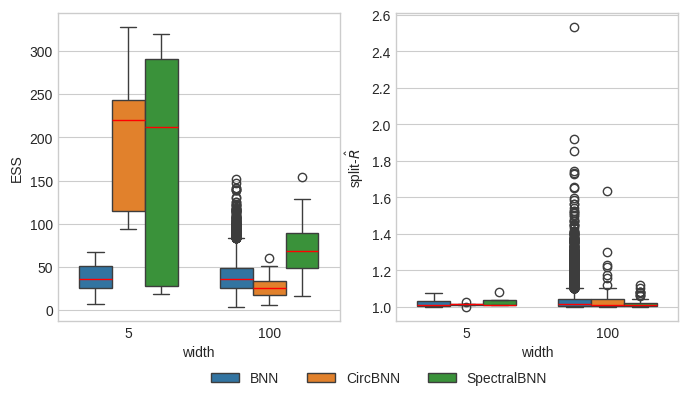

In [9]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(8, 4), sharex=False, sharey=False)
sns.boxplot(data=d, x="width", y="ESS", hue="model", width=0.7, medianprops={"color": "r"}, ax=axs[0])
sns.boxplot(data=d, x="width", y=rhat_label, hue="model", width=0.7, medianprops={"color": "r"}, ax=axs[1], legend=False)
sns.move_legend(axs[0], "lower left", bbox_to_anchor=(0.5, -0.25), ncol=3, title="", frameon=False)

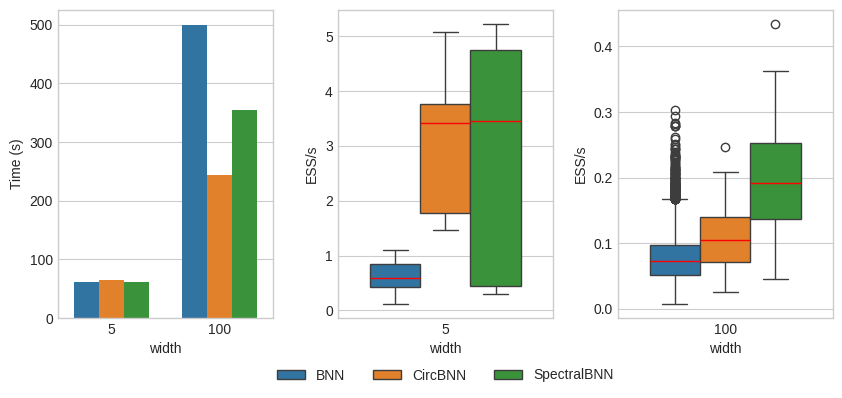

In [10]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(10, 4), sharex=False, sharey=False)
sns.barplot(data=d, x="width", y="Time (s)", hue="model", width=0.7, ax=axs[0], legend=False)
sns.boxplot(data=d.loc[d["width"] == 5], x="width", y="ESS/s", hue="model", width=0.7, medianprops={"color": "r"}, ax=axs[1], legend=True)
sns.boxplot(data=d.loc[d["width"] == 100], x="width", y="ESS/s", hue="model", width=0.7, medianprops={"color": "r"}, ax=axs[2], legend=False)
plt.subplots_adjust(wspace=0.3)
sns.move_legend(axs[1], "lower center", bbox_to_anchor=(0.5, -0.25), ncol=3, title="", frameon=False)

In [11]:
from scipy.stats import mannwhitneyu

# Perform Mann-Whitney U test and prepare the table
results_table = []
def bold_if_significant(value, significant):
    return f"$\\mathbf{{{value}}}$" if significant else f"${value}$"
for model in ["BNN", "CircBNN", "SpectralBNN"]:
    for width in [5, 100]:
        for method in ["HMC", "SVI"]:
            for split in d["split"].unique():
                baseline = d[(d["model"] == "BNN") & (d["width"] == width) & (d["method"] == method) & (d["split"] == split)]
                comparison = d[(d["model"] == model) & (d["width"] == width) & (d["method"] == method) & (d["split"] == split)]

                if len(baseline) == 0 or len(comparison) == 0:
                    continue

                # Extract values
                ess_baseline = baseline["ESS"]
                ess_comparison = comparison["ESS"]
                rhat_baseline = baseline[rhat_label]
                rhat_comparison = comparison[rhat_label]
                ess_s_baseline = baseline["ESS/s"]
                ess_s_comparison = comparison["ESS/s"]

                # Perform Mann-Whitney U test
                ess_stat, ess_p = mannwhitneyu(ess_baseline, ess_comparison, alternative="less")
                rhat_stat, rhat_p = mannwhitneyu(rhat_baseline, rhat_comparison, alternative="greater")
                ess_s_stat, ess_s_p = mannwhitneyu(ess_s_baseline, ess_s_comparison, alternative="less")

                # Significance
                ess_significant = ess_p < 0.05
                rhat_significant = rhat_p < 0.05
                ess_s_significant = ess_s_p < 0.05

                # Append results
                results_table.append({
                    "model": model,
                    "width": width,
                    "Time": f"{comparison['Time (s)'].mean() : .3f}",
                    "Speedup": f"{baseline['Time (s)'].mean() / comparison['Time (s)'].mean() : .3f}",
                    "Acceptance Prob": f"{comparison['Acceptance Prob'].mean() : .3f}",
                    "ESS": bold_if_significant(f"{comparison['ESS'].mean() : .3f}\\pm{comparison['ESS'].std() : .3f}", ess_significant),
                    "R-hat": bold_if_significant(f"{comparison[rhat_label].mean() : .3f}\\pm{comparison[rhat_label].std() : .3f}", rhat_significant),
                    "ESS/s": bold_if_significant(f"{comparison['ESS/s'].mean() : .3f}\\pm{comparison['ESS/s'].std() : .3f}", ess_s_significant),
                })

# Convert results to a DataFrame and display
results_df = pd.DataFrame(results_table)
results_df
#d.groupby(by=["model", "method", "width", "split"]).mean()

,model,width,Time,Speedup,Acceptance Prob,ESS,R-hat,ESS/s
0,BNN,5,60.648,1.000,0.936,$ 37.548\pm 15.247$,$ 1.019\pm 0.021$,$ 0.619\pm 0.251$
1,BNN,100,500.354,1.000,0.924,$ 38.893\pm 17.814$,$ 1.035\pm 0.061$,$ 0.078\pm 0.036$
2,CircBNN,5,64.680,0.938,0.936,$\mathbf{ 200.137\pm 96.094}$,$ 1.013\pm 0.010$,$\mathbf{ 3.094\pm 1.486}$
3,CircBNN,100,243.701,2.053,0.942,$ 26.635\pm 11.148$,$ 1.039\pm 0.079$,$\mathbf{ 0.109\pm 0.046}$
4,SpectralBNN,5,61.229,0.991,0.910,$ 173.716\pm 143.158$,$ 1.029\pm 0.032$,$ 2.837\pm 2.338$
5,SpectralBNN,100,355.188,1.409,0.901,$\mathbf{ 70.311\pm 28.230}$,$\mathbf{ 1.017\pm 0.023}$,$\mathbf{ 0.198\pm 0.079}$


In [12]:
d

,model,method,width,split,ESS,split-$\hat{R}$,Time (s),ESS/s,Acceptance Prob
0,BNN,HMC,5,0,57.185614,1.010134,60.647832,0.942913,0.9363914
1,BNN,HMC,5,0,26.316265,1.038156,60.647832,0.433919,0.9363914
2,BNN,HMC,5,0,55.064044,1.005224,60.647832,0.907931,0.9363914
3,BNN,HMC,5,0,23.923057,0.999001,60.647832,0.394459,0.9363914
4,BNN,HMC,5,0,66.927942,1.003137,60.647832,1.103550,0.9363914
...,...,...,...,...,...,...,...,...,...
10230,SpectralBNN,HMC,100,0,72.059130,1.022983,355.188491,0.202876,0.90066326
10231,SpectralBNN,HMC,100,0,95.764021,1.020606,355.188491,0.269615,0.90066326
10232,SpectralBNN,HMC,100,0,128.848557,1.008967,355.188491,0.362761,0.90066326
10233,SpectralBNN,HMC,100,0,96.806727,1.001477,355.188491,0.272550,0.90066326


# UCI Benchmark table (similar to Table 2 in Stein paper)

In [13]:
rows = []
key = jax.random.PRNGKey(SEED)
dataset_keys = jax.random.split(key, len(os.listdir(SAMPLE_PATH)))
for key, dataset_name in zip(dataset_keys, os.listdir(SAMPLE_PATH)):
    if not os.path.isdir(os.path.join(SAMPLE_PATH, dataset_name)):
        continue
    model_keys = jax.random.split(key, len(os.listdir(os.path.join(SAMPLE_PATH, dataset_name))))
    if dataset_name in dataset_names:
        dataset = UCIDataset(dataset_name)
        for key, file_name in zip(model_keys, os.listdir(os.path.join(SAMPLE_PATH, dataset_name))): 
            if file_name[-3:] == ".nc":
                model_key = key
                model_name = "_".join(file_name.split("_")[:-1])
                model = bnns.model_configs.__dict__[model_name]
                split_ind = int(file_name.split("_")[-1].split(".")[0])
                az_data = az.from_netcdf(os.path.join(SAMPLE_PATH, dataset_name, file_name))
                samples = az_data.to_dict()["posterior"]
                splits = load_standard_splits(True)[dataset_name]
                split = splits[split_ind]["te"]
                test_X = dataset.data[split][:, :-1]
                test_y = dataset.data[split][:, -1]
                nll = -log_likelihood(model, samples, X=test_X, y=test_y, batch_ndims=2, parallel=True)["y"]
                predictive = Predictive(model, posterior_samples=samples, return_sites=["y"], batch_ndims=2, parallel=True)
                predicted_ys = predictive(model_key, X=test_X, y=None, D_Y=1)["y"]
                rmse = jnp.sqrt(((test_y - predicted_ys)**2).mean())
                rows.append({"dataset": dataset_name, "model": model_name, "split": split_ind, "nll": nll.mean(), "rmse": rmse})
df = pd.DataFrame(rows)

In [14]:
df.groupby(["dataset", "model"]).mean()

KeyError: 'dataset'

In [ ]:
dataset.data[splits[1]["tr"]][:,:-1].std(0).mean()

Array(1.0077528, dtype=float32)

# Report plots

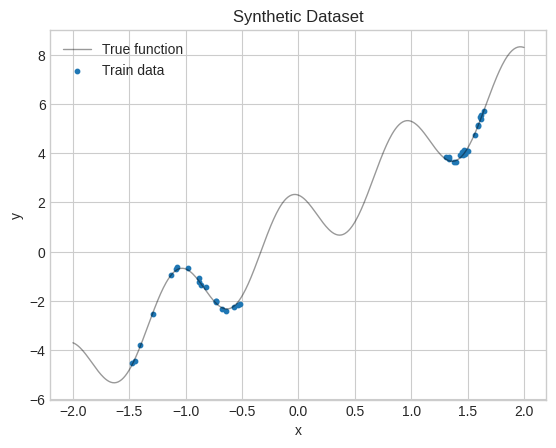

In [ ]:
# Plot the data with the underlying function
dataset = SyntheticDataset()
plt.title("Synthetic Dataset")
plt.plot(dataset.X_true, dataset.y_true, lw=1, c="black", alpha=0.4, label="True function")
plt.scatter(dataset.X_train, dataset.y_train, s=10, label="Train data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

In [ ]:
# Plot box plot of ESS
boxplot = []
for sample_dict in samples:
    if sample_dict["method"] == "SVI":
        continue
    # post_draws = sample["post_draws"].copy()
    # if "Spectral" in sample["model"]:
    #     for i in range(7):
    #         post_draws.pop(f"w_hat_{i}", None)
    summary = numpyro.diagnostics.summary(post_draws)
    ess = summary["w1"]["n_eff"].flatten() if "w1" in summary else summary["w_hat_0_normals"]["n_eff"].flatten()
    time_spanned = sample_dict["time_spanned"]
    for e in ess:
        boxplot.append({"ess": e, "time_spanned": float(time_spanned), "ESS/s": e / time_spanned, "Model": sample_dict["model"], "width": sample_dict["model"].split("_")[1]})
boxplot = pd.DataFrame(boxplot)
#sns.barplot(data=boxplot, x="model", y="time_spanned", hue="width")
#g = sns.FacetGrid(boxplot, col="width", col_wrap=3, height=3, sharey=False)
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(8, 8))
x_tick_labels = ["BNN", "CircBNN", "SpectralBNN"]
sns.barplot(ax=axs[0], data=boxplot, x="width", y="time_spanned", hue="Model")
sns.barplot(ax=axs[0], data=boxplot, x="width", y="time_spanned", hue="Model")
sns.boxplot(ax=axs[1], data=boxplot, x="width", y="ESS/s", hue="Model")
sns.boxplot(ax=axs[1], data=boxplot, x="width", y="ESS/s", hue="Model")
axs[0,0].set_title("5 hidden units")
axs[0,1].set_title("100 hidden units")
axs[0,0].set_xlabel(None)
axs[0,1].set_xlabel(None)
axs[0,0].set_ylabel("Time (s)")
axs[0,1].set_ylabel(None)
axs[1,1].set_ylabel(None)
axs[0,0].set_xticklabels(x_tick_labels)
axs[0,1].set_xticklabels(x_tick_labels)
axs[1,0].set_xticklabels(x_tick_labels)
axs[1,1].set_xticklabels(x_tick_labels)

/home/rasmuslovstad/Programs/assignments/thesis/venv/lib64/python3.11/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rasmuslovstad/Programs/assignments/thesis/venv/lib64/python3.11/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


AssertionError: 